### Aether Services 

Aether services allow you to interact with OKAPI:Aether in multiple ways. This page provides illustrated examples to help you get started. We first import dependencies and declare variables which will be useful for our use case. The test data can be downloaded <a href="../testdata/aether_services_api.zip" download>here</a> while the notebook itself may be fetched <a href="./aether_services.ipynb" download>here</a>.

In [1]:
import json
import pandas as pd
import datetime
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
import os
from okapi_aether_sdk.aether_services_api import AetherServicesApi

# Ensure that the .env file is populated with the required entries for authentication
aether_api = AetherServicesApi()
aether_api.login()

max_iter = 10 # Maximum number of get requests to be sent
wait_time = 30 # seconds between each get request

# The below code is used to load data from a repository to illustrate the use of the Aether Services API.
here = globals()['_dh'][0]
testdata = here / "testdata" / "aether_services_api"

#### Add Ephemerides

This service allows the user to upload ephemerides for a satellite to OKAPI:Aether. The formats supported for the payload can be found [here](https://okapiorbits.space/api-doc/#tag/developers/operation/addAddEphemeridesRequests).

The example shows the addition of NavSol data for a fictitious satellite with NORAD ID 12345. Note that a satellite must exist in OKAPI:Aether, otherwise the upload of ephemerides will not work. To upload your satellite with its properties, refer to the example page [Aether Satellites](aether_satellites.ipynb). 

In this example, an orbit determination is performed for the object once the ephemerides are uploaded by the user. The resulting orbit is propagated by numerical integration and screened for conjunctions. The raw NavSol data must first be wrapped into a proper payload, as shown below. The payload can then be sent using the `add_ephemerides` method.

NOTE: The bare_navsol.txt file contains records on individual lines, as shown below: 
```
SpacecraftTime,GNSS_S_ITOW,GNSS_S_FTOW,GNSS_S_WEEK,GNSS_S_GPSFIX,GNSS_S_TOWSET,GNSS_S_WKNSET,GNSS_S_DIFFSOLN,GNSS_S_GPSFIXOK,GNSS_S_ECEFX,GNSS_S_ECEFY,GNSS_S_ECEFZ,GNSS_S_PACC,GNSS_S_ECEFVX,GNSS_S_ECEFVY,GNSS_S_ECEFVZ,GNSS_S_SACC,GNSS_S_PDOP,GNSS_S_NUMSV
2021/04/30 00:00:00.240000,432018000,-224400,2155,3,True,True,False,True,128760841,16575059,-678742965,551,600149,-463648,102460,22,121,16
2021/04/30 00:00:29.190000,432047000,-262606,2155,3,True,True,False,True,146069400,3086385,-675423725,359,593420,-466515,126126,21,123,15
2021/04/30 00:01:00.237000,432078000,-303441,2155,3,True,True,False,True,164345222,-11415926,-671121539,309,585545,-469025,151268,19,103,16
```

In [2]:
with open(os.path.join(testdata, "add-ephemerides", "bare_navsol.txt"), "r", encoding="utf-8") as fp:
    navsol_lines = fp.readlines()
# With the following line, we make the NavSol data a single string
navsol = r'\n'.join(navsol_lines)

In [3]:
request = {
    "ephemerides": {
        "type": "navsol",
        "content": {
            "id": {
                "type": "norad_id",
                "content": 12345
                },
            "lines": navsol}
            }
    }

request_id = aether_api.add_ephemerides(ephemeris_to_add=request)
print(request_id)

8a312279-52fd-4685-95f4-d73d1645889d


Once the request is sent, the user may periodically check for results. The simplest result can be obtained by passing the result_format argument as "simple" which allows to obtain a status update on the upload of ephemerides. Alternatively, the results can be obtained in an OEM format, which is what is performed hereafter. The code below awaits nominal results from the `add_ephemerides` method and then plots the resulting orbit determination residuals. Note that this process will take some minutes as the orbit determination must be performed, then propagated and screened for conjunctions.

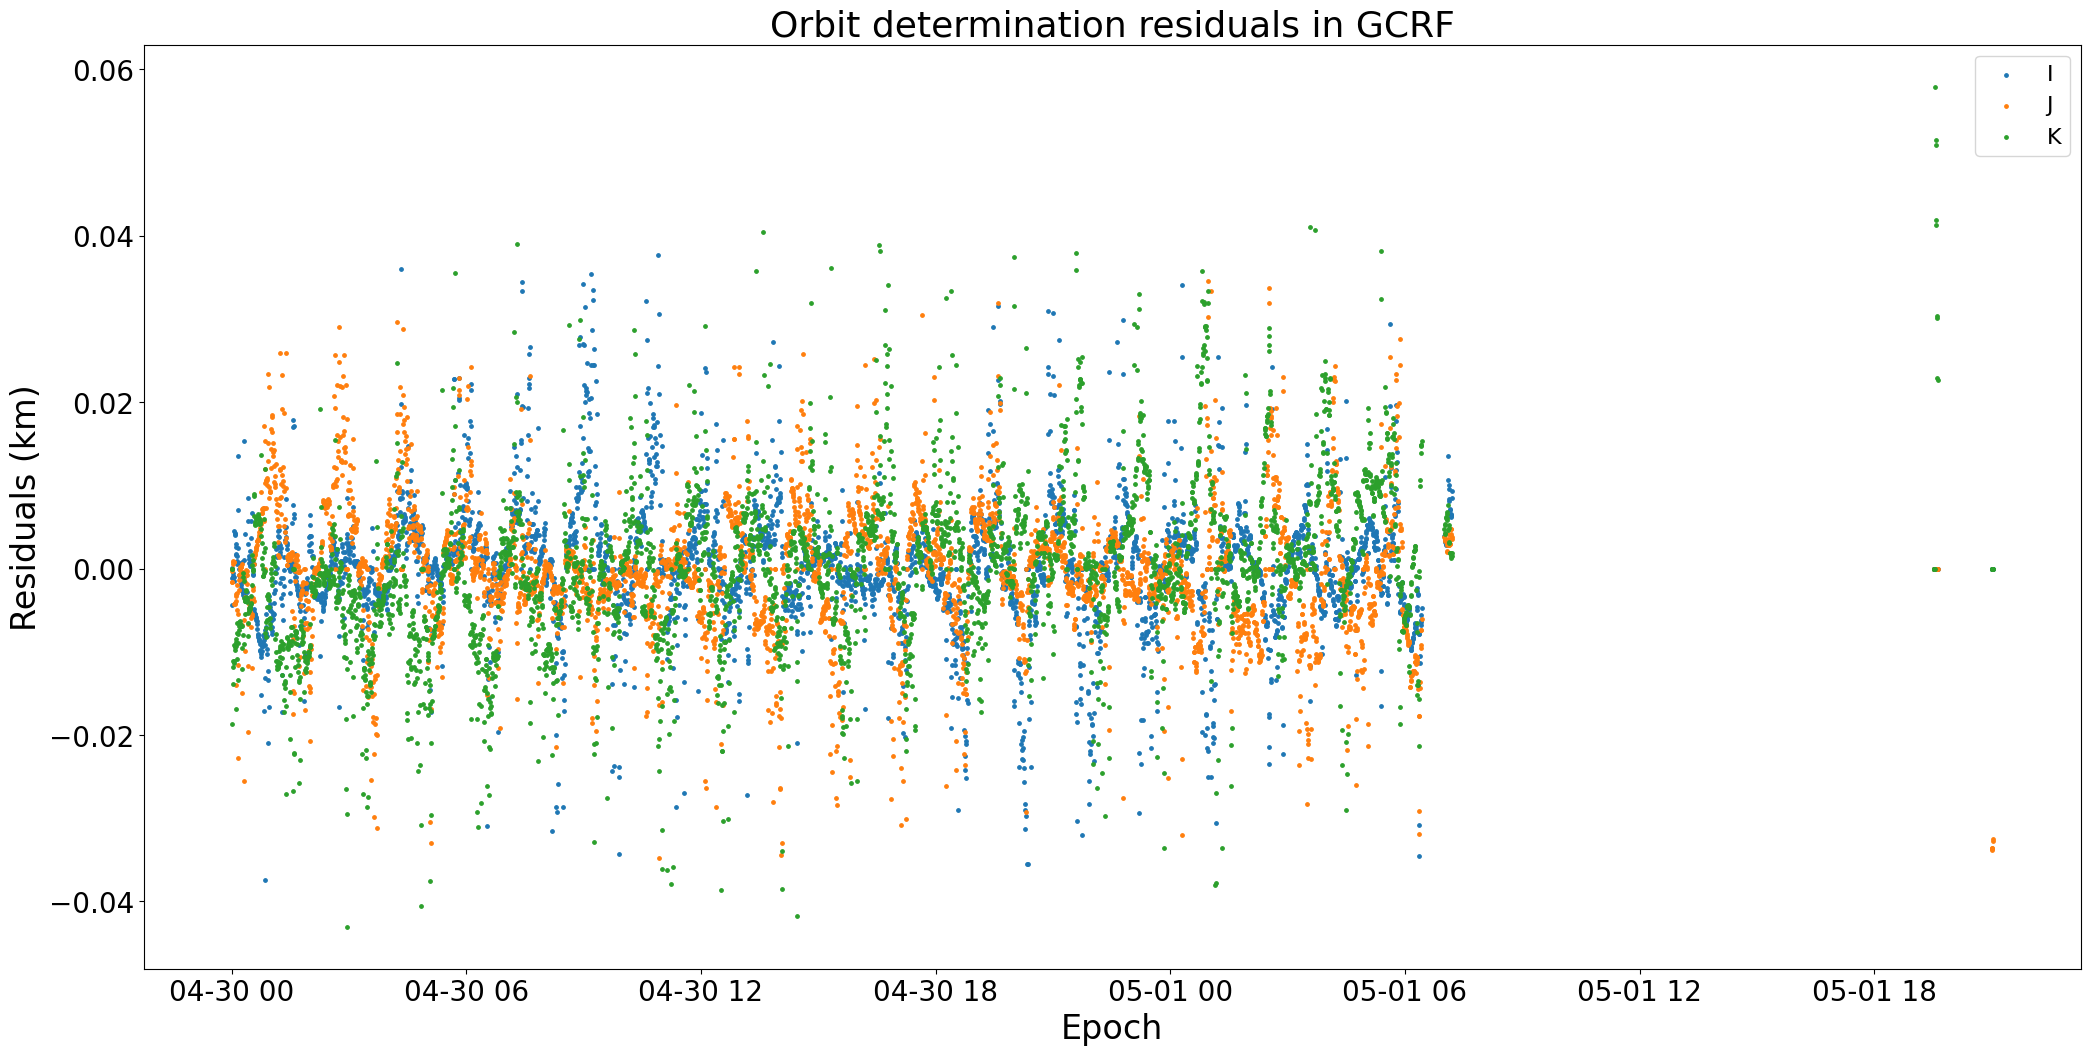

In [4]:
result_oem = aether_api.get_add_ephemerides_results(request_id, result_format="oem", 
                                                       max_retries=max_iter,
                                                       retry_delay=wait_time)
if "orbit" in result_oem:
    data = pd.DataFrame(result_oem["orbit"]["OEM_META_DATA_DATA"][0]["DATA"])
    data["EPOCH"] = pd.to_datetime(data["EPOCH"])
    fig, ax = plt.subplots(figsize=(25, 12))
    ax.set_xlabel("Epoch", fontsize=24)
    ax.set_ylabel("Residuals (km)", fontsize=24)
    ax.set_title("Orbit determination residuals in GCRF", fontsize=26)
    ax.tick_params(axis='both', labelsize=20)
    ax.scatter(data["EPOCH"], data["USER_DEFINED_RESIDUAL_1"], label="I", s=6)
    ax.scatter(data["EPOCH"], data["USER_DEFINED_RESIDUAL_2"], label="J", s=6)
    ax.scatter(data["EPOCH"], data["USER_DEFINED_RESIDUAL_3"], label="K", s=6)
    fig.legend(loc="upper right", fontsize=16, bbox_to_anchor=(0.9,0.88))
    plt.show()

#### Check Orbit

This service allows the user to check an orbit for conjunctions. The formats supported for the payload can be found [here](https://okapiorbits.space/api-doc/#tag/developers/operation/addOrbitCheckRequests). The resulting dictionary contains a "violations" key with an array as value. When the array is empty as is the case here, no conjunctions were found for the checked orbit.

In [5]:
with open(os.path.join(testdata, "check-orbit", "check_orbit_data.json"), "r") as fp:
    request = json.load(fp)   
request_id = aether_api.check_orbit(request_body=request)
result = aether_api.get_check_orbit_results(request_id,
                                            max_retries=max_iter,
                                            retry_delay=wait_time)
print(result["violations"])

[]


#### Correlate Observation

This service allows the user to attempt a correlation of measurements with a satellite. The formats supported for the payload can be found [here](https://okapiorbits.space/api-doc/#tag/developers/operation/addCorrelateObservationSingleRequest). Depending on results, a dictionary will be returned with the format outlined below. In our example, the observation could not be correlated to any existing orbit in OKAPI:Aether.
```
{
  "result": {
    "correlation_results": [
      {
        "norad_id": 0,
        "wrms": 0,
        "wsigma": 0,
        "figure_of_merit": 0,
        "list_track_correlation_residuals": [
          {
            "epoch": "2014-12-31T23:59:59.124Z",
            "range": 1200,
            "angle_1": 0,
            "angle_2": 90,
            "range_residual": 17.888723640053126,
            "angle_1_residual": 0.001,
            "angle_2_residual": 0.04,
            "angular_distance": 0.1
          }
        ]
      }
    ],
    "quality_index": 0
  },
  "status": {
    "type": "NONE",
    "text": "No messages",
    "input_problem": false
  }
}
```

In [6]:
with open(os.path.join(testdata, "correlate-observation", "correlate_observation_data.json"), "r") as fp:
    request = json.load(fp)   
request_id = aether_api.correlate_observation(target_observation=request)
result = aether_api.get_correlate_observation_results(request_id,
                                                      max_retries=max_iter,
                                                      retry_delay=wait_time)
print(result)

{'status': {'type': 'WARNING', 'text': 'No ephemerides found for the correlation process.', 'input_problem': False}}


#### Determine Orbit

This service uses supplied measurements to perform an orbit determination with the Weighted Least Squares (WLS) method. Formats for the request can be found [here](https://okapiorbits.space/api-doc/#tag/developers/operation/addOdWlsRequests). In the example below, measurements are in the topocentric right ascension and declination reference frame. The residuals of the orbit determination process in that reference frame are plotted which enables to visually assess the fit quality and number of outliers.

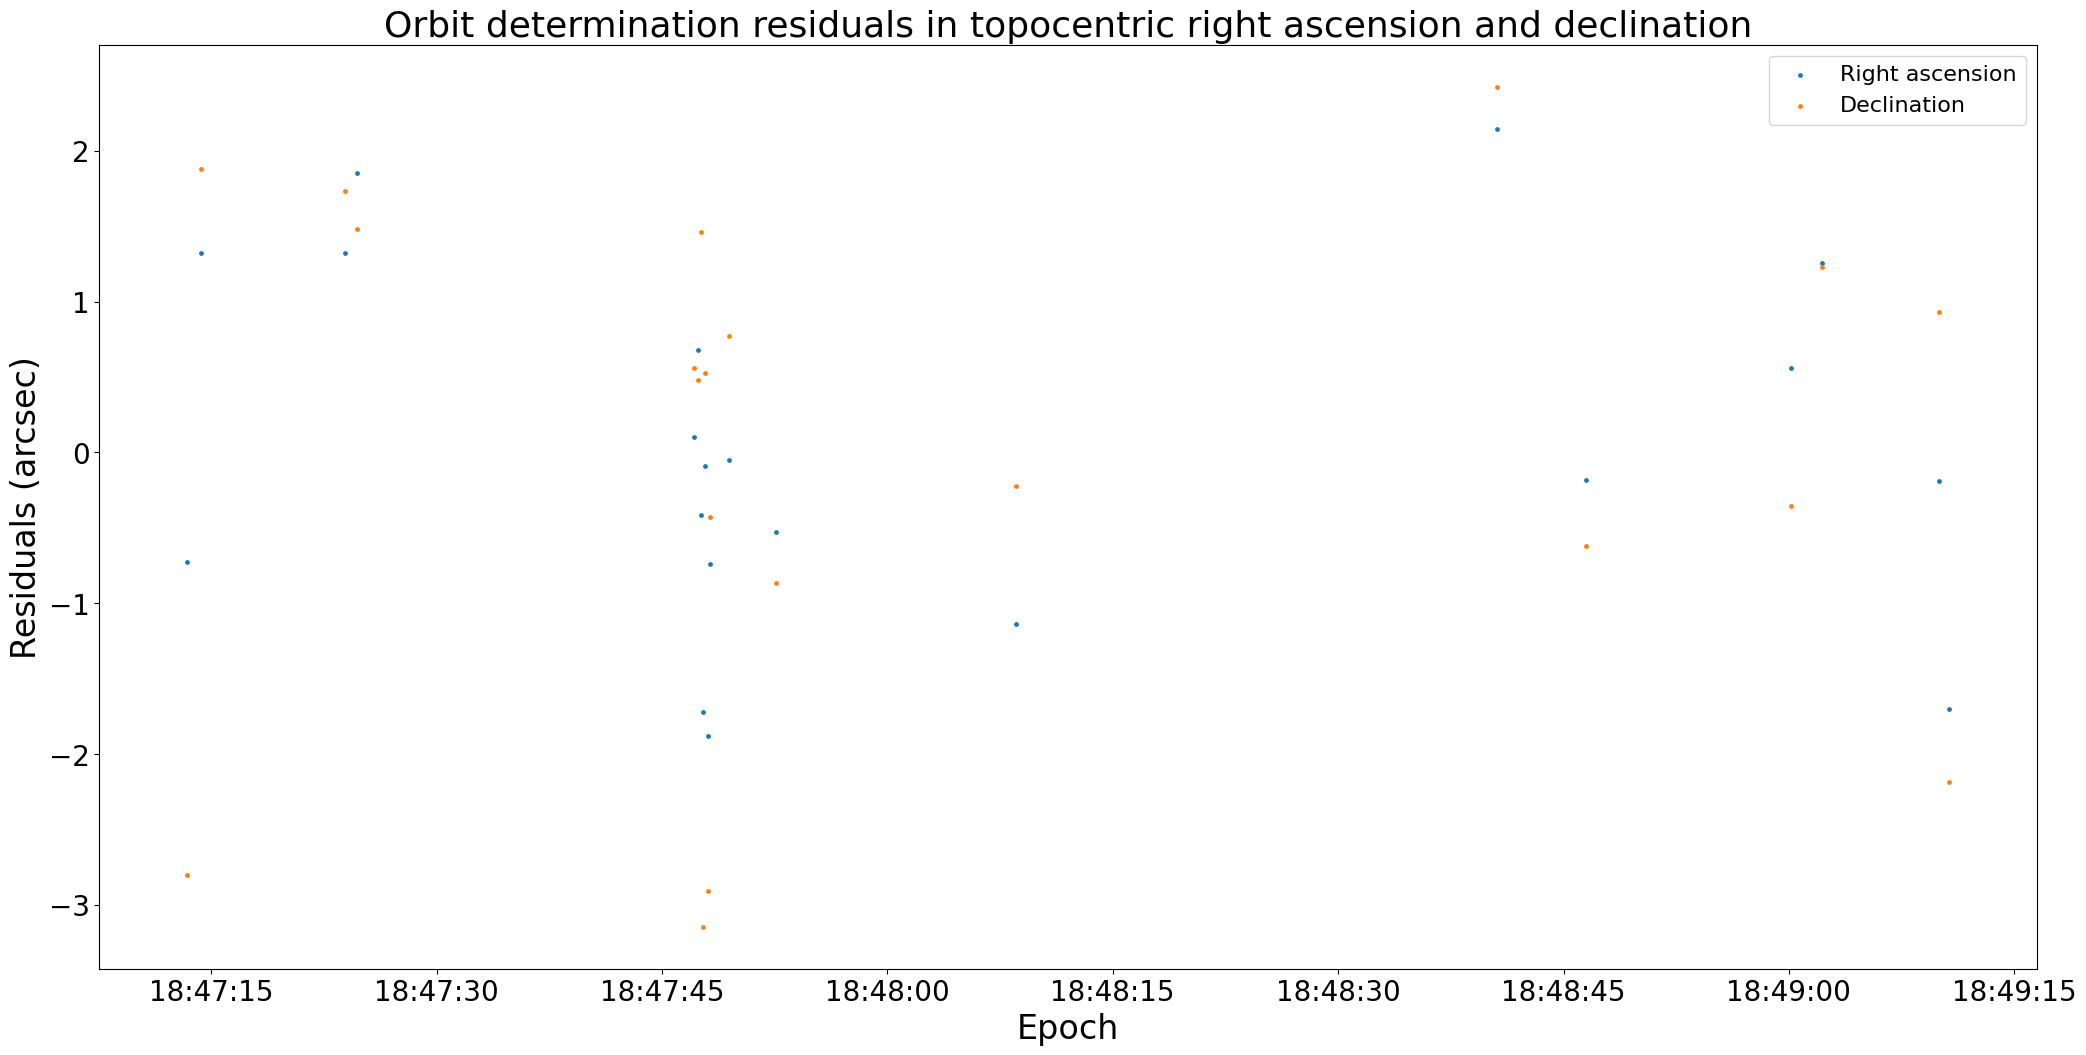

In [7]:
with open(os.path.join(testdata, "determine-orbit", "determine_orbit_data.json"), "r") as fp:
    request = json.load(fp)   
request_id = aether_api.determine_orbit(od_request=request)
result = aether_api.get_determine_orbit_results(request_id,
                                                max_retries=max_iter,
                                                retry_delay=wait_time)
# Plot the residuals of the orbit determination, and store the orbit determination results
if 'od_result' in result:
    data = pd.DataFrame(result["od_result"]["ephemerides"])
    data["epochGd"] = pd.to_datetime(data["epochGd"])
    fig, ax = plt.subplots(figsize=(25, 12))
    ax.set_xlabel("Epoch", fontsize=24)
    ax.set_ylabel("Residuals (arcsec)", fontsize=24)
    ax.set_title("Orbit determination residuals in topocentric right ascension and declination", fontsize=26)
    ax.tick_params(axis='both', labelsize=20)
    ax.scatter(data["epochGd"], data["residual_2"]*3600, label="Right ascension", s=6)
    ax.scatter(data["epochGd"], data["residual_3"]*3600, label="Declination", s=6)
    fig.legend(loc="upper right", fontsize=16, bbox_to_anchor=(0.9,0.88))
    plt.show()

#### Propagate Orbit

In contrast with the `determine_orbit` method obtaining an orbit based on a set of measurements, the `propagate_orbit` uses an existing orbit to predict the evolution in time using the numerical propagator requested by the user. For TLEs, the propagator selected should be SGP4, whereas NEPTUNE is the preferred choice for other ephemerides formats. The formats supported for the payload can be found [here](https://okapiorbits.space/api-doc/#tag/developers/operation/addNeptunePropagationRequests) for NEPTUNE propagations, and [here](https://okapiorbits.space/api-doc/#tag/developers/operation/addSGP4PropagationRequests) for SGP4 propagations.

In the example below, the two types of propagation are performed. Note that the result_formats for SGP4 are "omm" and "simple".

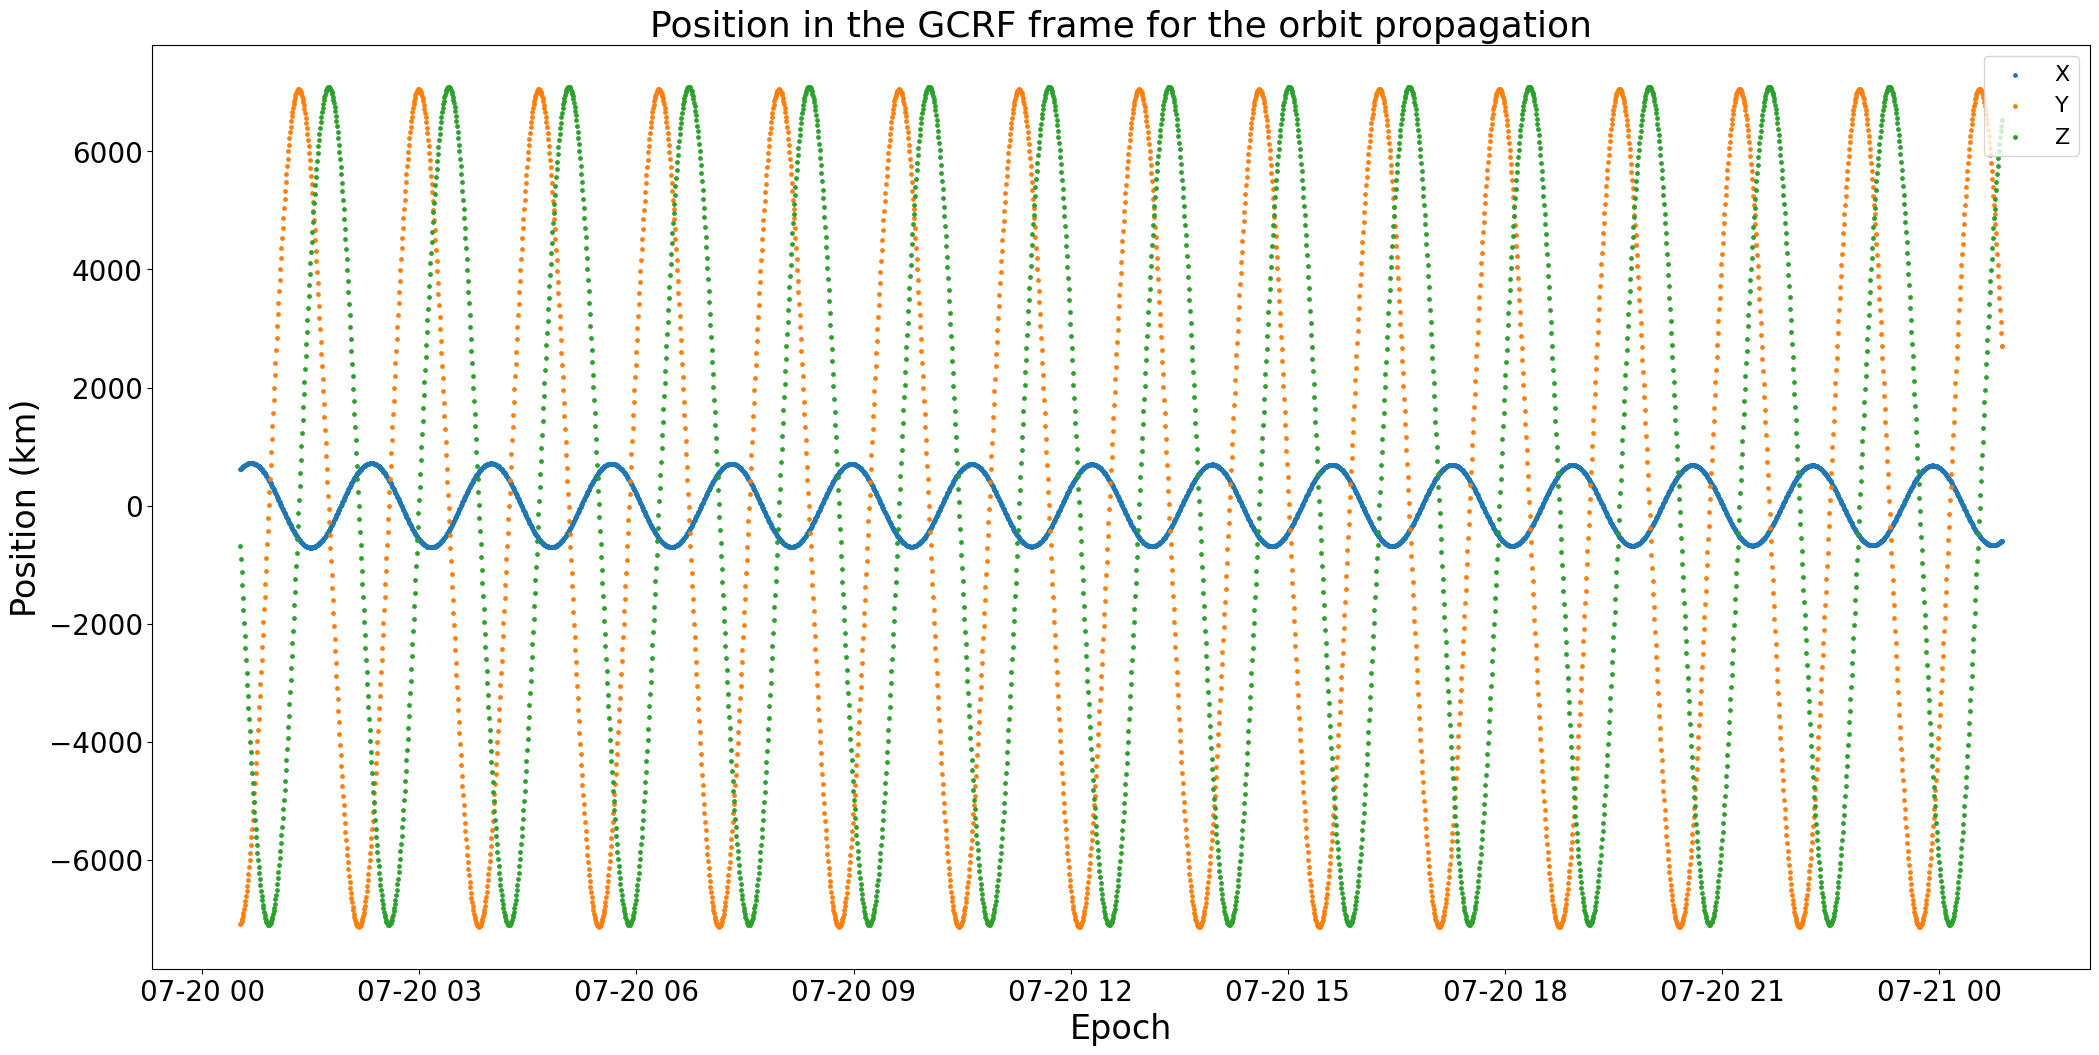

In [8]:
# Requesting a propagation with NEPTUNE
with open(os.path.join(testdata, "propagate-orbit", "propagate_orbit_neptune_data.json"), "r") as fp:
    request = json.load(fp)

request_id = aether_api.propagate_orbit(request_body=request, method="neptune")

# Retrieve the result of the orbit propagation as an OEM 
result = aether_api.get_propagate_orbit_results(request_id, method="neptune", result_format="oem",
                                                max_retries=max_iter,
                                                retry_delay=wait_time)

if "orbit" in result:
    data = pd.DataFrame(result["orbit"]["OEM_META_DATA_DATA"][0]["DATA"])
    data["epochGd"] = pd.to_datetime(data["EPOCH"])
    fig, ax = plt.subplots(figsize=(25, 12))
    ax.set_xlabel("Epoch", fontsize=24)
    ax.set_ylabel("Position (km)", fontsize=24)
    ax.set_title("Position in the GCRF frame for the orbit propagation", fontsize=26)
    ax.tick_params(axis='both', labelsize=20)
    ax.scatter(data["epochGd"], data["X"], label="X", s=6)
    ax.scatter(data["epochGd"], data["Y"], label="Y", s=6)
    ax.scatter(data["epochGd"], data["Z"], label="Z", s=6)
    fig.legend(loc="upper right", fontsize=16, bbox_to_anchor=(0.9,0.88))
    plt.show()

# Requesting a propagation with SGP4
with open(os.path.join(testdata, "propagate-orbit", "propagate_orbit_sgp4_data.json"), "r") as fp:
    request = json.load(fp)

request_id = aether_api.propagate_orbit(request_body=request, method="sgp4")

result = aether_api.get_propagate_orbit_results(request_id, method="sgp4", result_format="omm",
                                                max_retries=max_iter,
                                                retry_delay=wait_time)

#### Predict Passes

The `predict_passes` method allows to obtain observability windows for an orbit from a given ground location for an interval in time. The orbit is propagated in time, and as for the `propagate_orbit` method, there are two methods available: NEPTUNE propagation and SGP4 propagation. The formats required for both of these [here](https://okapiorbits.space/api-doc/#tag/developers/operation/addPassPredOEMRequests) and [here](https://okapiorbits.space/api-doc/#tag/developers/operation/addPassPredSGP4Requests).

The below example shows how both propagation types can be used. The results of the NEPTUNE propagation are then plotted to show the topocentric right ascension and declination values for the observable pass.

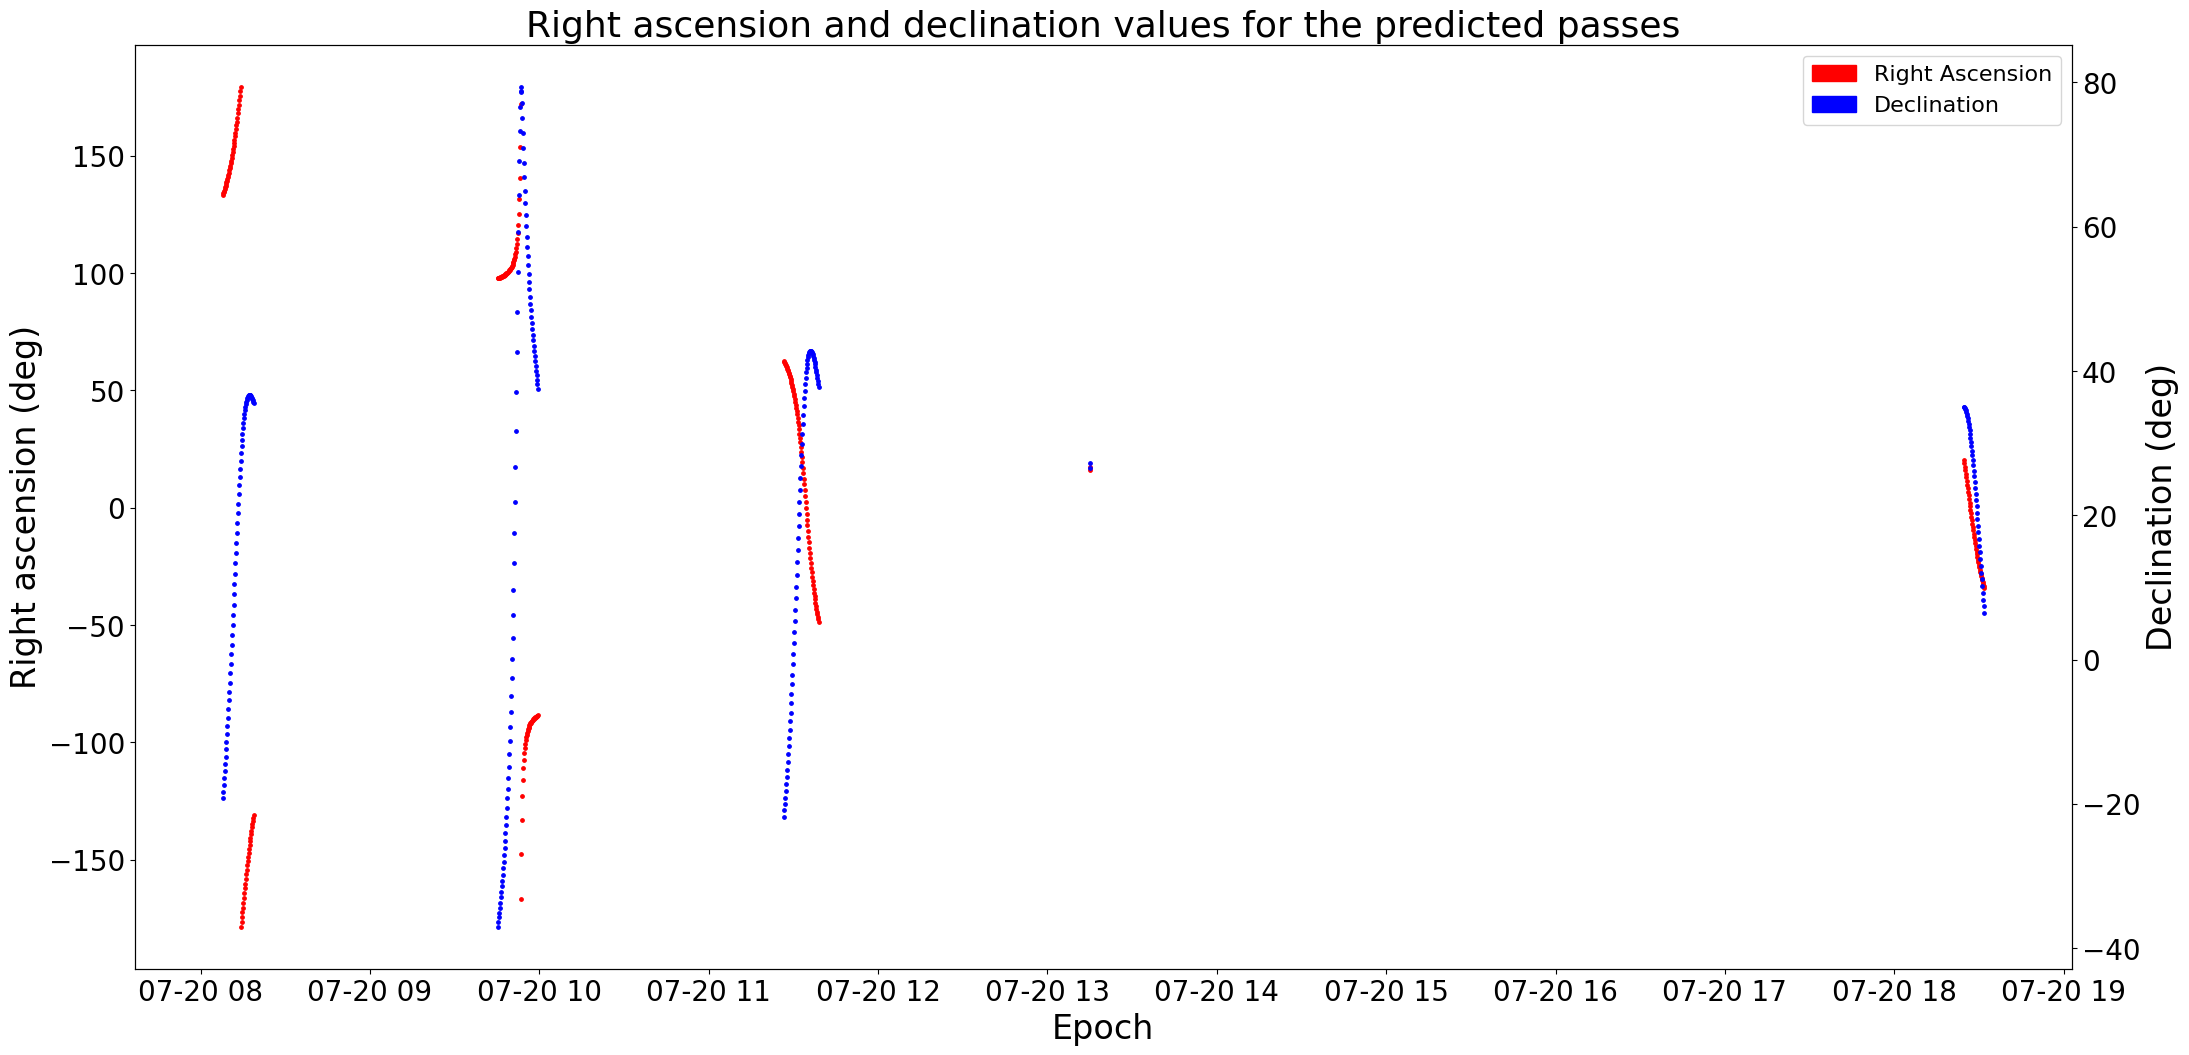

In [9]:
# Requesting a propagation with NEPTUNE to find the passes over sensors
with open(os.path.join(testdata, "predict-passes", "predict_passes_neptune_data.json"), "r") as fp:
    request = json.load(fp)
request_id = aether_api.predict_passes(request_body=request, method="neptune")
result = aether_api.get_predict_passes_results(request_id, method="neptune", result_format="simple",
                                               max_retries=max_iter,
                                               retry_delay=wait_time)
# Plot the passes if any are present in the time window
if result["passes"]:
    fig, ax = plt.subplots(figsize=(25, 12))
    ra_patch = mpatches.Patch(color='red', label='Right Ascension')
    dec_patch = mpatches.Patch(color='blue', label='Declination')
    ax.set_xlabel("Epoch", fontsize=24)
    ax.set_ylabel("Right ascension (deg)", fontsize=24)
    ax.set_title("Right ascension and declination values for the predicted passes", fontsize=26)
    ax.tick_params(axis='both', labelsize=20)
    ax_2 = ax.twinx()
    ax_2.set_ylabel("Declination (deg)", fontsize=24)
    for pass_ in result["passes"]:
        epochs_dt = [datetime.datetime.fromisoformat(i) for i in pass_["time_stamps"]]
        ax.scatter(epochs_dt, pass_["right_ascensions"], s=6, c="r")
        ax_2.scatter(epochs_dt, pass_["declinations"], s=6, c="b")
    ax_2.tick_params(axis='y', labelsize=20)
    fig.legend(handles=[ra_patch, dec_patch], loc="upper right", fontsize=16, bbox_to_anchor=(0.9,0.88))
    plt.show()

# Requesting a propagation with SGP4 to find the passes over sensors
with open(os.path.join(testdata, "predict-passes", "predict_passes_sgp4_data.json"), "r") as fp:
    request = json.load(fp)
request_id = aether_api.predict_passes(request_body=request, method="sgp4")
result = aether_api.get_predict_passes_results(request_id, method="sgp4", result_format="simple",
                                               max_retries=max_iter,
                                               retry_delay=wait_time)

#### Estimate Risk

The `estimate_risk` method allows the user to evaluate the collision risk for a CDM using a selected method such as one from this non-exhaustive list: "alfano-2005", "alfriend-1999", "all-methods", "chan-1997", "foster-1992", "maximum-probability", "monte-carlo", "patera-2001", "patera-2003". This allows to obtain the probability of collision, the B-plane and more. More information can be found at OKAPI:Orbits' API documentation. For this example, the alfano-2005 method is to be used, with formats for the payload as shown [here](https://okapiorbits.space/api-doc/#tag/developers/operation/addRiskEstimationAlfano2005Requests).

In [10]:
with open(os.path.join(testdata, "estimate-risk", "estimate_risk_data.json"), "r") as fp:
    request = json.load(fp)
request_id = aether_api.estimate_risk(request_body=request, method="alfano-2005")
result = aether_api.get_estimate_risk_results(request_id, method="alfano-2005",
                                              max_retries=max_iter,
                                              retry_delay=wait_time)
if "risk_estimations" in result:
    print(f"Time of closest approach (TCA): {result['risk_estimations'][0]['tca']}")
    print(f"Collision probability (%): {result['risk_estimations'][0]['collision_probability']*100}")
    print(f"Mahalanobis distance: {result['risk_estimations'][0]['mahalanobis_distance']}")
    print(f"Miss distance (km): {result['risk_estimations'][0]['miss_distance']}")

Time of closest approach (TCA): 2019-10-03T06:44:12.007Z
Collision probability (%): 0.15635535810546716
Mahalanobis distance: 3.1676401862484007
Miss distance (km): 0.1434763964898678


#### Predict Risk

The `predict_risk` method runs a risk prediction algorithm for a CDM, essentially predicting the evolution of the probability of collision over time. It distinguishes itself from the `estimate_risk` method by providing the evolution of the probability of collision in time, instead of a single instantaneous value for the probability of collision. Information can be found [here](https://okapiorbits.space/api-doc/#tag/developers/operation/addRiskPredictionAlfano2005Requests) for the example below.

In [11]:
with open(os.path.join(testdata, "predict-risk", "predict_risk_data.json"), "r") as fp:
    request = json.load(fp)
request_id = aether_api.predict_risk(request_body=request, method="alfano-2005")
result = aether_api.get_predict_risk_results(request_id, method="alfano-2005",
                                              max_retries=max_iter,
                                              retry_delay=wait_time)
if "risk_predictions" in result:
    print(f"Time of closest approach (TCA): {result['risk_predictions'][0]['tca']}")
    print(f"Collision probability (%): {result['risk_predictions'][0]['collision_probability']*100}")
    print(f"Probability of being critical (%): {result['risk_predictions'][0]['probability_of_critical']*100}")
    print(f"Miss distance (km): {result['risk_predictions'][0]['miss_distance']}")

Time of closest approach (TCA): 2019-10-03T06:44:12.007Z
Collision probability (%): 8.601989235163963e-07
Probability of being critical (%): 18.099999999999998
Miss distance (km): 0.1434763964898678


#### Generate Maneuver

The `generate_maneuver` method allows to generate for a conjunction identifier (for a satellite in OKAPI:Aether) a maneuver, based on optional additional constraints beyond the existing ones for the asset. It is recommended to look at the information concerning payload formatting and available constraints [here](https://okapiorbits.space/api-doc/#tag/developers/operation/addGenManeuverNEPTUNERequests).

In [12]:
with open(os.path.join(testdata, "generate-maneuver", "generate_maneuver_data.json"), "r") as fp:
    request = json.load(fp)
request_id = aether_api.generate_maneuver(request_body=request)
result = aether_api.get_generate_maneuver_results(request_id,
                                                  max_retries=max_iter,
                                                  retry_delay=wait_time)
if "cam_result_data" in result:
    for maneuver in result['cam_result_data'][0]['maneuver_file']['OPM_DATA']['MANEUVERS']:
        print(f"Maneuver EPOCH: {maneuver['MAN_EPOCH_IGNITION']}")
        print(f"Maneuver duration (s): {maneuver['MAN_DURATION']}")

Maneuver EPOCH: 2020-10-13T18:56:28.968Z
Maneuver duration (s): 100
Maneuver EPOCH: 2020-10-13T20:32:59.597Z
Maneuver duration (s): 100
Maneuver EPOCH: 2020-10-13T22:08:19.341Z
Maneuver duration (s): 80.27999999999997


#### Maneuver Execution Analysis

This service allows the user to check whether a commanded maneuver has been executed nominally. More information on payload formatting  can be found [here](https://okapiorbits.space/api-doc/#tag/developers/operation/addManeuverExecutionAnalysisRequests).

In [13]:
with open(os.path.join(testdata, "maneuver-execution-analysis", "maneuver_execution_analysis_data.json"), "r") as fp:
    request = json.load(fp)
request_id = aether_api.maneuver_execution_analysis(request_body=request)
result = aether_api.get_maneuver_execution_analysis_results(request_id,
                                                            max_retries=max_iter,
                                                            retry_delay=wait_time)
if "executed" in result:
    if result["executed"]:
        print("The maneuver has been executed")
    else:
        print("The maneuver has not been executed")

The maneuver has been executed


#### Estimate Covariance

The last service covered in this guide is the `estimate_covariance` method. This allows to estimate the resulting covariance for a satellite from planned measurements. More extensive information can be found [here](https://okapiorbits.space/api-doc/#tag/developers/operation/addEstimateCovarianceSingleRequest).

In [14]:
with open(os.path.join(testdata, "estimate-covariance", "estimate_covariance_data.json"), "r") as fp:
    request = json.load(fp)
request_id = aether_api.estimate_covariance(target_covariance=request)
result = aether_api.get_estimate_covariance_results(request_id,
                                                    max_retries=max_iter,
                                                    retry_delay=wait_time)
if "after_update" in result:
    print(f"Covariance after update: {result['after_update']}")

Covariance after update: {'x_x': 5386.135652051498, 'x_y': 1556.0956571474105, 'x_z': -576.3343136292273, 'x_x_dot': -0.4395412180384656, 'x_y_dot': -0.3997933974208479, 'x_z_dot': 0.03600633735143342, 'y_y': 557.7560641784752, 'y_z': -166.88932209347155, 'y_x_dot': -0.143251994698011, 'y_y_dot': -0.1150980085004197, 'y_z_dot': 0.011308540707853934, 'z_z': 178.1208677480666, 'z_x_dot': 0.0473778573461512, 'z_y_dot': 0.0427775308464058, 'z_z_dot': -0.013103470604559025, 'x_dot_x_dot': 4.918937560020927e-05, 'x_dot_y_dot': 3.236102149151764e-05, 'x_dot_z_dot': -4.284726888021504e-06, 'y_dot_y_dot': 2.9680906184369235e-05, 'y_dot_z_dot': -2.6472160854918225e-06, 'z_dot_z_dot': 1.843763367583458e-06}
